# ABC Presentation

In [2]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, KernelDensity
using LaTeXStrings
using ProgressMeter
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

### **Alorithm 1** - Likelihood-free rejection sampler 1
Let's use sampling from Uniform with binomial likelihood function to illustrate this algorithm.


In [3]:
n, x = 8, 6 #Binomial experiment
N = 1000    #sample

# Sample θ' from prior π(θ)
theta_s = rand(Beta(1,1),N)

# Generate z from p(.|θ')
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

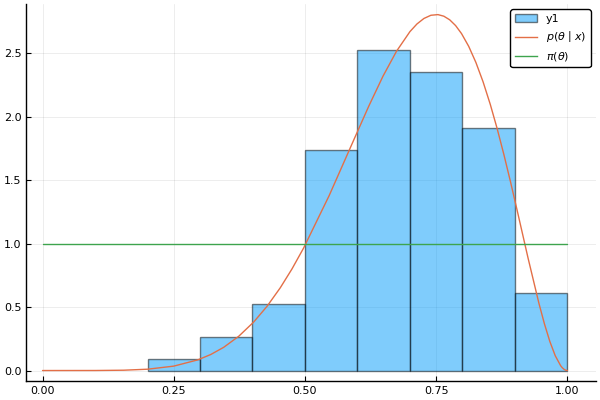

In [4]:
histogram(theta_a,normalize=true,alpha=0.5)
plot!(Beta(x+1,n-x+1),label=L"p(\theta \mid x)")
plot!(Beta(1,1), label =L"\pi(\theta)")

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


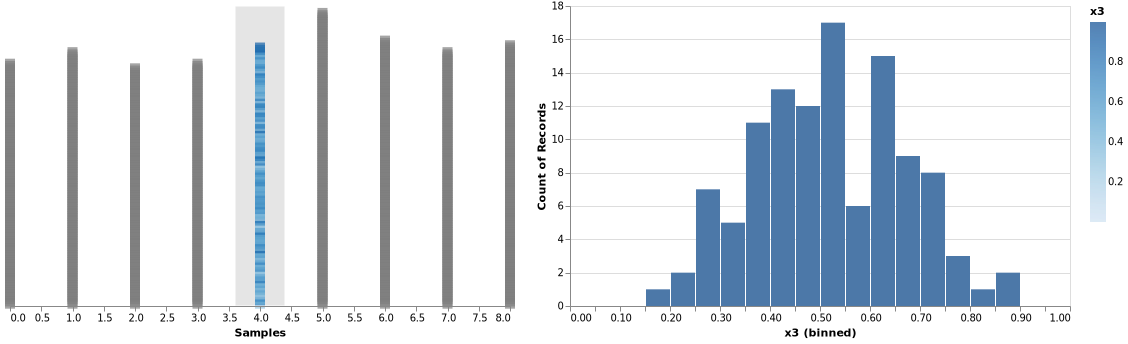

In [5]:
cm = countmap(z)
counter = zeros(length(cm))
hdots = zeros(N)
for (i,v) in enumerate(z)
    counter[v+1]+=1
    hdots[i] = counter[v+1]
end


df = DataFrame([z,hdots,theta_s,collect(1:length(z))]);

points = df |> vl"""
{
"hconcat" : [
  {
    "view":{"stroke" : null},
    "layer": [{

    
    "selection": {
      "brush": {"type": "interval","encodings": ["x"],"init":{"x": [3.6, 4.4]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": "square",
    "encoding": {
        "x": {"field": "x1", "type": "quantitative","axis": {"grid":false, "title":"Samples"}},
        "y": {"field": "x2", "type": "quantitative", "axis": null},
        "size":{"value":100},
        "color": {
              "condition": {"selection": "brush", "field": "x3", "type": "quantitative"},
              "value": "grey"
            }
        }
}]},
  {
    "layer":[{
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
    "mark": "bar",
    "encoding": {
    "x": {
        "bin":{"maxbins":20},
        "field": "x3",
        "type": "quantitative"
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative"
      }
    }}
    ]
}]
}
"""

### **Alorithm 2** - Likelihood-free rejection sampler 2

Let's write the functions for calculating the distances between the variables.

**Auxiliary Functions** 

In [15]:
MA(current, u,t) = u[current+2] + u[current + 1] * t[1] + u[current] * t[2]

function genMA(u,t,n,N)
    z = zeros(N,n)
        for i=1:N
            z[i,:] = MA.((1:n),Ref(u[i,:]),Ref(t[i,:]))
        end
    return z
end

raw_distance(y,z)         = sqrt(sum((y-z).^2))
function abcautocov_distance(y,z)
    ay = 0
    az = 0
    for i = 2:length(y)
        ay +=y[i]*y[i-1]
        az +=z[i]*z[i-1]
    end
    ay2 = 0
    az2 = 0
    for i = 3:length(y)
        ay2 +=y[i]*y[i-2]
        az2 +=z[i]*z[i-2]
    end
    rho = (ay - az)^2+(ay2 - az2)^2 +(sum(y.^2)- sum(z.^2))^2 # Codigo com lag = 0 apresentou melhor resultado aparentemente
#     rho = (ay - az)^2+(ay2 - az2)^2
    return rho
end

function rand_TriUniform(N=1)
    trisample = zeros(N,2)
    count = 0
    while count < N
        theta = [4*rand()-2;2*rand()-1]
        if (theta[1]>-2 && theta[1]<2) && (sum(theta)>-1) && (theta[1]-theta[2] < 1)
            count+=1
            trisample[count,:] = theta
        end
    end
    return trisample
end
autocov_vectorize(z)    = abcautocov_distance(y,z)
dist_vectorize(z)       = raw_distance(y,z)

function Ger_Simga(θ1,θ2, y)
    Σ = zeros(100,100)
    for i=1:length(y)
        if i == 1
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        elseif i == 99
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
        elseif i == 100
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
        else
            Σ[i,i-2] = θ2
            Σ[i,i-1] = θ1 + θ1*θ2
            Σ[i,i]   = 1 + θ1^2 + θ2^2
            Σ[i,i+1] = θ1 + θ1*θ2
            Σ[i,i+2] = θ2
        end
    end

    return Σ
end

Ger_Simga (generic function with 1 method)

##### **Synthetic Dataset**
###### Moving Average model (MA)
$y_k = u_k + \sum_{i=1}^q \theta_i u_{k-i}$

$y \sim MA(q)$

$(\theta_1,\theta_2) =(0.6,0.2)$,sample size of 100.

In [11]:
using Random
Random.seed!(3)
theta = [0.6;0.2]
n     = 100
u     = randn(n+2)
y     = MA.((1:n),Ref(u),Ref(theta));

##### **Running ABC** 

In [12]:
# Random.seed!(1)
N = 10^6        # number of trials
n = length(y) # sample size
theta_s = rand_TriUniform(N)
u       = randn(N,n+2)
z       = genMA(u,theta_s,n,N);

In [14]:
rho_autocov = mapslices(autocov_vectorize, z, dims =2)[:];
epsilon10e4_autocov = quantile(rho_autocov,0.1/100)
theta_ac_auto = theta_s[rho_autocov .< epsilon10e4_autocov,:];

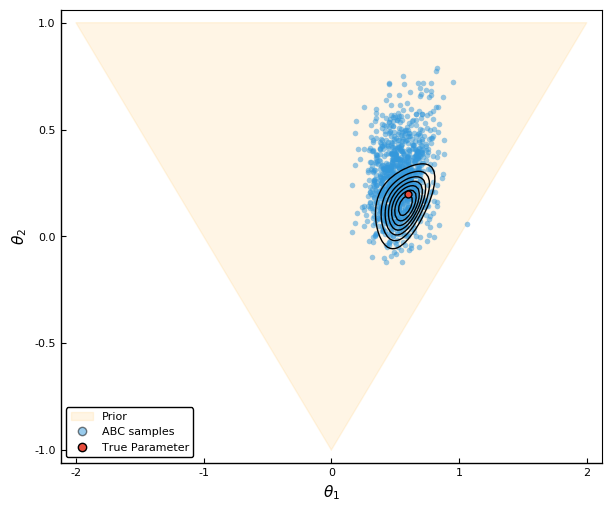

In [28]:
plot(Plots.P2[(0,-1),(-2,1),(2,1),(0,-1)],fill=true,color=:orange,alpha=0.1,label="Prior")
scatter!(theta_ac_auto[:,1],theta_ac_auto[:,2],xlims=[-2,2],alpha=0.5,markerstrokewidth=0,
    c="#3498db", label="ABC samples")


# Contour Plot - True posterior
gθ1      = -0:0.02:1
gθ2      = -0.5:0.02:0.5
gridθ1   = repeat(reshape(gθ1, 1, :), length(gθ2), 1)
gridθ2   = repeat(gθ2, 1, length(gθ1))
mamvn(θ1,θ2) = pdf(MvNormal(zeros(100),Ger_Simga(θ1,θ2,y)),y)
Z = map(mamvn, gridθ1, gridθ2)
p1 = contour!(gθ1,gθ2, mamvn, fill=false,c=:black,levels=8,
    xlabel=L"\theta_1", ylabel=L"\theta_2",colorbar=false)

s = scatter!([theta[1]],[theta[2]],markersize=5,c="#e74c3c",size=(600,500),
    framestyle=:box,grid=false, label="True Parameter")
savefig(s, "./images/ABCmodel1.png")